/Users/Joy/anaconda2/lib/python2.7/site-packages/xgboost-0.81-py2.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/Joy/anaconda2/lib/python2.7/site-packages/xgboost-0.81-py2.7.egg/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


all5lib_25deep_RD-
      test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
0           1.110803       0.072254         1.113116        0.004931
1           1.105293       0.072282         1.107633        0.004806
2           1.100738       0.072277         1.103054        0.004708
3           1.096010       0.071966         1.098346        0.004889
4           1.090220       0.071485         1.092501        0.005086
5           1.085142       0.071576         1.087340        0.005010
6           1.080580       0.071794         1.082703        0.004557
7           1.076303       0.071873         1.078368        0.004467
8           1.071196       0.071900         1.073164        0.004135
9           1.066813       0.072026         1.068723        0.004076
10          1.062159       0.071694         1.064125        0.004738
11          1.057679       0.071450         1.059581        0.004735
12          1.052739       0.070820         1.054846        0.005328
13          1.0

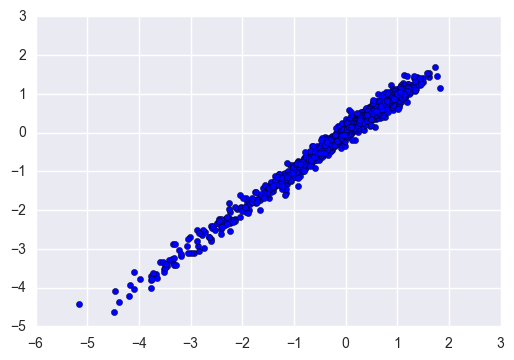

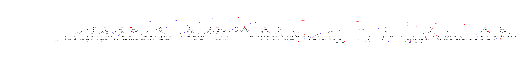

In [1]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
import pickle
import xgboost 
import shap
import numpy as np
import sklearn
import pandas as pd
from collections import OrderedDict
from xgboost import plot_importance
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import mean_absolute_error
from sklearn import tree
from scipy.stats import skew
from collections import OrderedDict
from sklearn.metrics import mean_squared_error
import seaborn as sns
sns.set()
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# load data
df=pd.read_csv("./data/all5lib_onehotwALLlabels.csv",header=0)
headername=list(df.columns.values)
aptamer='all5lib_25deep'
max_depth=25

#############################################

k=68
X=df.iloc[:,0:68]
Y=df.iloc[:,k]
#     Y=[np.nan if np.isnan(x) else x for x in df.iloc[:,k]]

data_dmatrix = xgboost.DMatrix(data=X,label=Y)

# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# ==========================================
xg_reg = XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = max_depth, alpha = 10, n_estimators = 24)
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.01,
                'max_depth': max_depth, 'alpha': 10}

cv_results = xgboost.cv(dtrain=data_dmatrix, params=params, nfold=15,
                    num_boost_round=5000,early_stopping_rounds=5,metrics="rmse", as_pandas=True, seed=123)

print aptamer+'_'+headername[k]
print cv_results

xg_reg.set_params(n_estimators=cv_results.shape[0])
print('Fit on the trainingsdata')
xg_reg.fit(X, Y)
pickle.dump(xg_reg, open(aptamer+'_'+headername[k]+".pickle.dat", "wb"))
%matplotlib inline
preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))
plt.scatter(y_test,preds)
# plt.show()

rsq=sklearn.metrics.r2_score(y_test,preds)
print("R-squared: %f" % (rsq))
xgboost.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [1000, 4000]
# plt.savefig('xan_regressor.eps', bbox_inches='tight')
plt.savefig(aptamer+'_xgbr_'+headername[k]+'.png', dpi=1000)
# fig.savefig('xan_regressor.eps', format='eps')
# plt.show()

#     df_nonan[headername[k]+"_pred"]=xg_reg.predict(X)
df[headername[k]+"_pred"]=xg_reg.predict(X)

RMSE: 0.117436


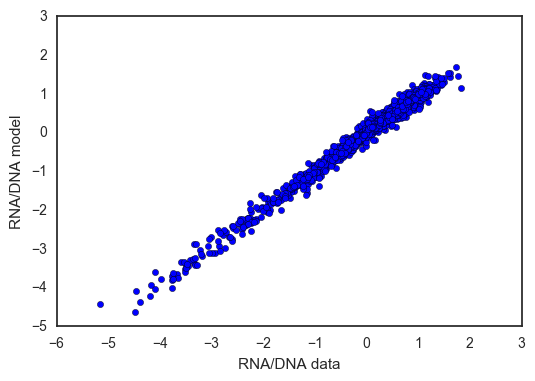

In [3]:
%matplotlib inline
preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))
sns.set(style="white")
plt.scatter(y_test,preds)
plt.xlabel('RNA/DNA data')
plt.ylabel('RNA/DNA model')

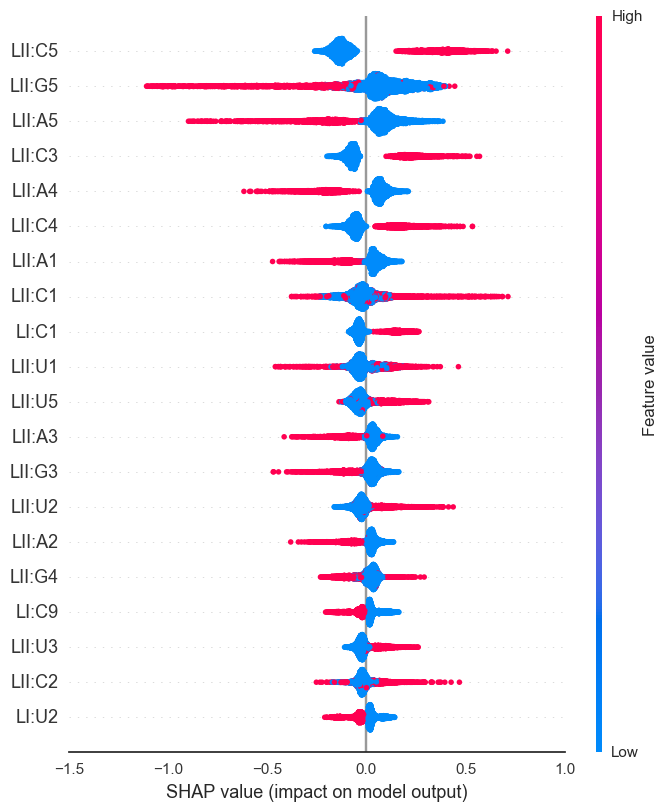

In [5]:
# load JS visualization code to notebook
shap.initjs()
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(X)

# summarize the effects of all the features
shap.summary_plot(shap_values, X)